과제 : 패션 데이터 지도 학습 시키기


In [24]:
from sklearn.datasets import fetch_openml
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

1. 데이터 준비

In [25]:
# 1. Load Data
mnist = fetch_openml('mnist_784', as_frame=True, parser='auto')

In [26]:
mnist.data.head(), mnist.target.head()

(   pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0       0       0       0       0       0       0       0       0       0   
 1       0       0       0       0       0       0       0       0       0   
 2       0       0       0       0       0       0       0       0       0   
 3       0       0       0       0       0       0       0       0       0   
 4       0       0       0       0       0       0       0       0       0   
 
    pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
 0        0  ...         0         0         0         0         0         0   
 1        0  ...         0         0         0         0         0         0   
 2        0  ...         0         0         0         0         0         0   
 3        0  ...         0         0         0         0         0         0   
 4        0  ...         0         0         0         0         0         0   
 
    pixel781  pixel782  pixel783  pixel784  
 0 

In [27]:
# 1-3. Split
target = mnist.target.astype(int).to_frame()
feature = mnist.data
print(target.shape, feature.shape)
print(type(target), type(feature))
print(target.nunique())

(70000, 1) (70000, 784)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
class    10
dtype: int64


2. Create DataSet

In [28]:
# 2-1. Define Dataset class
class fashion_dataset(Dataset):
    def __init__(self, x_data, y_data):  # 초기화 함수
        super().__init__()
        x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data  
        y_data = y_data.values if isinstance(y_data, pd.DataFrame) else y_data
        
        # ndarray ==> Tensor
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.LongTensor(y_data)

    def __len__(self):  # 갯수 확인 콜백 함수
        return self.target.shape[0]

    def __getitem__(self, index):   # 특정 인덱스 데이터+라벨 반환 콜백 함수
        return self.feature[index], self.target[index]

In [29]:
# 2-2. Set my_dataset
my_dataset = fashion_dataset(feature, target)
# my_dataset[0], feature.iloc[0], target.iloc[0]

In [30]:
# 2-3. Split train, validate, test
from torch.utils.data import random_split

seed = torch.Generator().manual_seed(11)

train_ds, val_ds, test_ds = random_split(my_dataset, [0.7, 0.1, 0.2], generator=seed)
print(f"[train, val, test] {len(train_ds), len(val_ds), len(test_ds)}")

[train, val, test] (49000, 7000, 14000)


3. Create DataLoader

In [46]:
# 3. Create dataLoader
batch = 160
train_dl = DataLoader(train_ds, batch_size=batch)
val_dl = DataLoader(val_ds, batch_size=batch)
test_dl = DataLoader(test_ds, batch_size=batch)
len(train_dl), len(val_dl), len(test_dl)

(307, 44, 88)

4. Define Model Class

In [47]:
# 4. define class
class ClassiModel(nn.Module):
    def __init__(self, in_dim, out_dim):
        in_to_hidden = 100
        hidden_to_out = 50
        super(ClassiModel, self).__init__()
        self.input_layer = nn.Linear(in_dim, in_to_hidden)
        self.relu = nn.ReLU()
        self.hidden_layer = nn.Linear(in_to_hidden, hidden_to_out)
        self.output_layer = nn.Linear(hidden_to_out, out_dim)

    def forward(self, x):
        y = self.input_layer(x)
        y = self.relu(y)
        y = self.hidden_layer(y)
        y = self.relu(y)
        y = self.output_layer(y)
        return y

5. Prepare Training

In [48]:
# 1) Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# 2) Train count
Epoch = 50
# 3) Model instance
IN, OUT = my_dataset.feature.shape[1], len(torch.unique(my_dataset.target))
# print(IN, OUT)
model = ClassiModel(IN, OUT).to(DEVICE)

# 4) loss func.
LOSS_FUNC = nn.CrossEntropyLoss().to(DEVICE)

# 5) Optimize instance
import torch.optim as optim

OPTIMIZER = optim.Adam(model.parameters(), lr=0.01)

# 6) Scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode="min", patience=10)

6. Define Train / Validate functions

In [49]:
import torchmetrics.functional as metrics

In [50]:
target.shape, target.squeeze().shape

((70000, 1), (70000,))

6-1. Train Function

In [51]:
def training(dataLoader, PRINT=False):
    model.train()   # training mode activate
    train_loss, train_acc = [], []
    for cnt, (dt_1b, target) in enumerate(dataLoader):
        dt_1b, target = dt_1b.to(DEVICE), target.to(DEVICE)   # Set to DEVICE
        target = target.squeeze()   # (70000,1) -> (70000,)
        
        pred = model(dt_1b)    # Prediction from feature
        
        loss = LOSS_FUNC(pred, target)    # Calculate loss function
        train_loss.append(loss)
        
        OPTIMIZER.zero_grad()   # Reset W, b
        loss.backward()         # Proceed backward to loss values
        OPTIMIZER.step()        # Update W, b
        
        acc = metrics.accuracy(pred, target, task="multiclass", num_classes=OUT)
        # print(acc)
        train_acc.append(acc)
    
    mean_train_loss = sum(train_loss)/len(train_loss)
    
    if PRINT:
        print(f'[ Total Train Run : {cnt+1} ]')
        print(f'Mean train loss : {mean_train_loss:.3f}, final accuracy : {sum(train_acc)/len(train_acc):.3f}')

    return mean_train_loss

training(train_dl, PRINT=True)  # for testing

[ Total Train Run : 307 ]
Mean train loss : 0.954, final accuracy : 0.830


tensor(0.9541, grad_fn=<DivBackward0>)

In [52]:
training(train_dl)

tensor(0.2693, grad_fn=<DivBackward0>)

6-2. Validate Function

In [53]:
def testing(dataLoader, PRINT=False):
    model.eval()   # testing mode activate
    
    with torch.no_grad():
        val_loss, val_acc = [], []
        for cnt, (dt_1b, target) in enumerate(dataLoader):
            dt_1b, target = dt_1b.to(DEVICE), target.to(DEVICE)
            target = target.squeeze()
            pred = model(dt_1b)
            
            loss = LOSS_FUNC(pred, target)
            val_loss.append(loss)
            
            acc = metrics.accuracy(pred, target, task="multiclass", num_classes=OUT)
            val_acc.append(acc)
            
        mean_val_loss = sum(val_loss)/len(val_loss)
        
        if PRINT:
            print(f'[ Total Test Run : {cnt+1} ]')
            print(f'Mean validation loss : {mean_val_loss:.3f}, final accuracy : {sum(val_acc)/len(val_acc):.3f}')
    
    return mean_val_loss

testing(val_dl, PRINT=True)

[ Total Test Run : 44 ]
Mean validation loss : 0.313, final accuracy : 0.920


tensor(0.3131)

6-3. Epochs

In [58]:
EOPOCH = 30
min_loss = 100
for epoch in range(EOPOCH):
    print(f'[Epoch : {epoch+1}]')
    
    train_loss, val_loss = training(train_dl, PRINT=True), testing(val_dl, PRINT=True)
    
    if min_loss > val_loss:
        min_loss = val_loss # 최초 최소 손실 업데이트 (반복용)
        
    if SCHEDULER.num_bad_epochs > SCHEDULER.patience:
        print('Early Stopping : Over patience limit')
        print('Min Loss :', min_loss)
        break
    elif min_loss < val_loss:   # 평가 손실 증가 시 종료
        print('Early Stopping : Increasing val_loss')
        print(f'Min Loss : {min_loss.item():.3f}')
        break
    else:
        pass
    

[Epoch : 1]
[ Total Train Run : 307 ]
Mean train loss : 0.519, final accuracy : 0.878
[ Total Test Run : 44 ]
Mean validation loss : 0.423, final accuracy : 0.913
[Epoch : 2]
[ Total Train Run : 307 ]
Mean train loss : 0.355, final accuracy : 0.919
[ Total Test Run : 44 ]
Mean validation loss : 0.506, final accuracy : 0.909
Early Stopping : Increasing val_loss
Min Loss : 0.423


손실 계수 값 : 0.423

6-4. Predict Function

In [77]:
from matplotlib import pyplot as plt

def predict(dataSet, LIMIT):
    model.eval()    # testing() 과 동일한 모델
    correction = 0  # 정확도 표현을 위한 변수
    
    for idx in range(len(dataSet)):
        img, TRUE = dataSet[idx][0], dataSet[idx][1]
        # 데이터셋의 데이터(이미지), 정답
        with torch.no_grad():
            pred = model(img.unsqueeze(0)).argmax(dim=1).item()
            # : 데이터 예측을 위한 array화
            
            # 28x28 그래프로 표현
            plt.figure(figsize=(1, 1))
            plt.imshow(np.array(img).reshape(28, 28), cmap='Blues')
            plt.title(f'Prediction : {pred}, Truth : {TRUE.item()}')
            plt.xticks([])
            plt.yticks([])
            plt.show()
            
            if pred == TRUE:
                correction += 1
            
            if idx+1 == LIMIT:
                break
    
    print(f'Accuracy : {correction/LIMIT*100:.2f}%')
    

7. Prediction

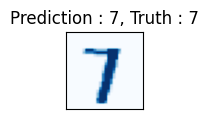

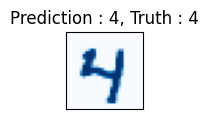

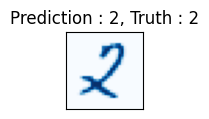

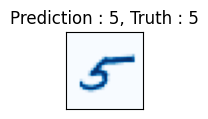

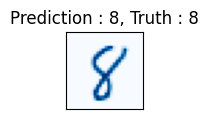

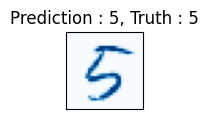

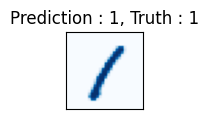

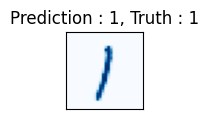

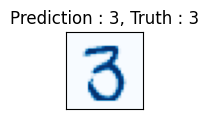

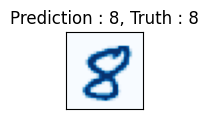

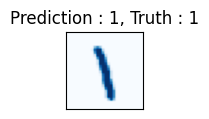

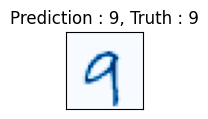

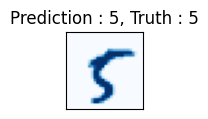

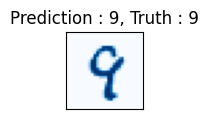

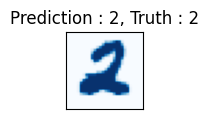

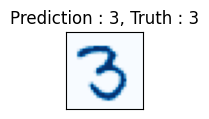

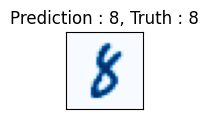

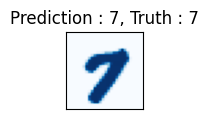

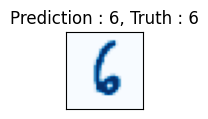

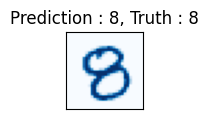

Accuracy : 100.00%


In [78]:
predict(test_ds, 20)

성능 완.벽.

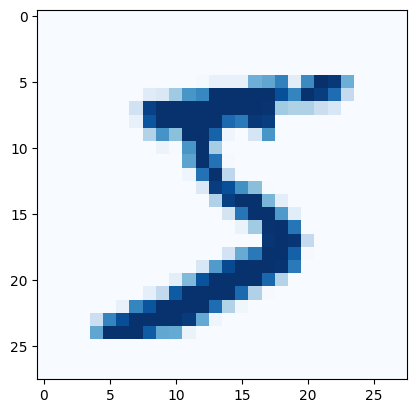

In [40]:
# 시각화 테스트

import matplotlib.pyplot as plt

# feature[0] 이미지화
plt.imshow(feature.iloc[0].values.reshape(28,28), cmap='Blues')


In [41]:
# 